In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Device Name:', torch.cuda.get_device_name(0))
print('Device Count:', torch.cuda.device_count())
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

Device: cuda
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU
Device Count: 1
System Version: 3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]
PyTorch version 2.6.0+cu126
Torchvision version 0.21.0+cu126
Numpy version 2.1.2
Pandas version 2.2.3


In [29]:
IMAGE_PATH = Path('dataset/')
IMAGE_PATH_LIST = list(IMAGE_PATH.glob('*/*'))
print(f'total images = {len(IMAGE_PATH_LIST)}')

total images = 1987


In [30]:
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 30)
print(" " * 17, "Total Images per class")
print("**" * 30)
for c in classes:
    imgs_class = len(list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg")))
    print(f"* {c} => {imgs_class} images")
print("**" * 30)

print("Classes:", classes)

************************************************************
                  Total Images per class
************************************************************
* glass => 501 images
* metal => 410 images
* paper => 594 images
* plastic => 482 images
************************************************************
Classes: ['glass', 'metal', 'paper', 'plastic']


In [31]:
path = [None] * len(IMAGE_PATH_LIST)
label = [None] * len(IMAGE_PATH_LIST)

for i,img_path in enumerate(IMAGE_PATH_LIST):
    path[i] = img_path
    label[i] = img_path.parent.stem
    
df_path_label = pd.DataFrame({"path":path, 
                              "label":label})

df_path_label.head()

,path,label
0,dataset\glass\glass_001.jpg,glass
1,dataset\glass\glass_002.jpg,glass
2,dataset\glass\glass_003.jpg,glass
3,dataset\glass\glass_004.jpg,glass
4,dataset\glass\glass_005.jpg,glass


In [32]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
SEED = 123

df_train, df_rest = train_test_split(df_path_label, 
                                     test_size = 0.3, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_path_label["label"])

df_valid, df_test = train_test_split(df_rest, 
                                     test_size = 0.5, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_rest["label"])

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_valid)}")
print(f"Test size: {len(df_test)}")
df_train.head()


Train size: 1390
Validation size: 298
Test size: 299


,path,label
1221,dataset\paper\paper_311.jpg,paper
1369,dataset\paper\paper_459.jpg,paper
1587,dataset\plastic\plastic_083.jpg,plastic
1944,dataset\plastic\plastic_440.jpg,plastic
1512,dataset\plastic\plastic_008.jpg,plastic


In [33]:
df_test.head()
df_train['label'].value_counts()

label
paper      416
glass      350
plastic    337
metal      287
Name: count, dtype: int64

In [34]:
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'glass': 0, 'metal': 1, 'paper': 2, 'plastic': 3}

In [35]:
df_train["label"] = df_train["label"].map(label_map)
df_valid["label"] = df_valid["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)
df_train.head()

,path,label
1221,dataset\paper\paper_311.jpg,2
1369,dataset\paper\paper_459.jpg,2
1587,dataset\plastic\plastic_083.jpg,3
1944,dataset\plastic\plastic_440.jpg,3
1512,dataset\plastic\plastic_008.jpg,3


In [36]:
df_train = df_train.reset_index(drop = True)
df_valid = df_valid.reset_index(drop = True)

In [37]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(260),  # Random crop to 260x260 for EfficientNet-B2
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.RandomRotation(15),  # Rotate randomly by ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),  # Apply affine transformation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

valid_transforms = transforms.Compose([
    transforms.Resize((260, 260)),  # Resize to 260x260 for EfficientNet-B2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [38]:
class CustomDataset:
    def __init__(self, df:pd.DataFrame, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        try:    
            image_path = self.df.iloc[idx, 0]
            image = Image.open(image_path).convert("RGB")
            image = self.transforms(image)
            label = self.df.iloc[idx, 1]

            return image,label
    
        except Exception as e:
            print(f"Error loading image: {image_path} -> {e}")
            return None

In [39]:
valid_dataset = CustomDataset(df_valid, valid_transforms)
train_dataset = CustomDataset(df_train, train_transforms)
test_dataset = CustomDataset(df_test, valid_transforms)

In [40]:
BATCH_SIZE = 16
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

valid_dataloader = DataLoader(dataset = valid_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

In [41]:
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([16, 3, 260, 260]), torch.Size([16]))

In [42]:
batch_labels

tensor([0, 2, 0, 3, 3, 2, 3, 2, 1, 0, 2, 3, 2, 1, 1, 0])

In [43]:
class WasteClassifier(nn.Module):
    def __init__(self, num_classes=4, model_name="efficientnet_b2", freeze_base=False):  # Changed to efficientnet_b2
        super(WasteClassifier, self).__init__()
        
        # Load EfficientNet model dynamically
        self.base_model = timm.create_model(model_name, pretrained=True, num_classes=0)  
        # Remove head
        # self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # Get feature extractor output size
        enet_out_size = self.base_model.num_features
        
        # Unfreeze the last few layers for fine-tuning
        if freeze_base:
            # Freeze most layers but keep last few unfrozen
            for param in list(self.base_model.parameters())[:-20]:
                param.requires_grad = False

        # Improved classifier with more regularization
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.BatchNorm1d(enet_out_size),
            nn.Dropout(0.4),
            nn.Linear(enet_out_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base_model.forward_features(x)
        return self.classifier(x)


In [44]:
model=WasteClassifier()
model.to(device)
print(str(model)[:500])

WasteClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)



In [45]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience (int): Number of epochs to wait after the last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, valid_loss):
        # print("EarlyStopping __call__ method called")
        # Check if validation loss improved
        if valid_loss < self.best_loss - self.min_delta:
            self.best_loss = valid_loss
            self.counter = 0  # Reset counter if improvement
        else:
            self.counter += 1  # Increment if no improvement
            print(f"Early Stopping counter: {self.counter}")

        # Check if patience is exceeded
        if self.counter >= self.patience:
            self.early_stop = True

In [46]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights_np = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(df_train['label']),
                                                 y=df_train['label'])

# --- Manually adjust weight for the 'paper' class ---
# First, find the index for 'paper'
paper_class_label_str = 'paper' # Make sure this matches the exact string in your 'classes' list
if paper_class_label_str in label_map:
    paper_class_index = label_map[paper_class_label_str]
    
    # Reduce the weight for the 'paper' class.
    # You can experiment with different reduction factors.
    # Example: reduce its calculated weight by 30% (multiply by 0.7)
    reduction_factor_paper = 0.7 
    if paper_class_index < len(class_weights_np):
        print(f"Original weight for '{paper_class_label_str}' (index {paper_class_index}): {class_weights_np[paper_class_index]}")
        class_weights_np[paper_class_index] *= reduction_factor_paper
        print(f"Adjusted weight for '{paper_class_label_str}': {class_weights_np[paper_class_index]}")
    else:
        print(f"Warning: Paper class index {paper_class_index} is out of bounds for class_weights_np.")
else:
    print(f"Warning: '{paper_class_label_str}' not found in label_map. Weights not adjusted for paper.")
# --- End of manual adjustment ---

class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)
print(f"Final class weights being used: {class_weights}")

# Define loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# Define optimizer with weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Original weight for 'paper' (index 2): 0.8353365384615384
Adjusted weight for 'paper': 0.5847355769230769
Final class weights being used: tensor([0.9929, 1.2108, 0.5847, 1.0312], device='cuda:0')


In [47]:
def train_step(model=model, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader , loss_fn=loss_fn, optimizer=optimizer, device=device):
    
    # Training phase
    model.train()
    running_train_loss = 0.0  # Renamed for clarity
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        # labels.pred_loit = model(images) # This line is redundant and can be removed

        # zero gradients
        optimizer.zero_grad()

        outputs = model(images)
        
        # Loss
        loss = loss_fn(outputs, labels)

        # Gradients = backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_dataloader)
    

    # Validation phase
    model.eval()
    running_valid_loss = 0.0 # Renamed for clarity
    with torch.inference_mode():
        for images, labels in valid_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Loss
            loss = loss_fn(outputs, labels)

            running_valid_loss += loss.item()
    val_loss = running_valid_loss / len(valid_dataloader)
    
    return train_loss, val_loss

In [48]:
# Function that stores the best model with the least loss in the validation set.
def save_checkpoint(filename, model, epoch, loss, optimizer):
    state = {"filename":filename, 
             "model":model.state_dict(), 
             "epoch":epoch, 
             "loss":loss, 
             "optimizer":optimizer.state_dict()}
    print(f"Saving model to {filename} at epoch {epoch} with loss {loss}")
    torch.save(model.state_dict(), filename)

In [49]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          valid_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int):
    
    results = {"train_loss":[], 
               "valid_loss":[],}
    
    best_valid_loss = float("inf")
    early_stopper = EarlyStopping(patience=5, min_delta=0.001)
    
    for epoch in range(epochs):
        
        train_loss, valid_loss= train_step(model = model, 
                                                train_dataloader = train_dataloader, 
                                                valid_dataloader = valid_dataloader,
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, 
                            model, 
                            epoch, 
                            best_valid_loss, 
                            optimizer)
            
        
        print(f"Epoch: {epoch + 1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Valid Loss: {valid_loss:.4f} | ")
        
        results["train_loss"].append(train_loss)
        results["valid_loss"].append(valid_loss)

        scheduler.step(valid_loss)
        # early_stopper = EarlyStopping(patience=5, min_delta=0.001)
        early_stopper(valid_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered. Stopping training.")
            break  # Exit training loop
        
    return results

Starting training...
Saving model to best_model.pth at epoch 0 with loss 0.7388279477232381
Epoch: 1 |  Train Loss: 0.5324 |  Valid Loss: 0.7388 | 
Saving model to best_model.pth at epoch 1 with loss 0.4598327083022971
Epoch: 2 |  Train Loss: 0.7094 |  Valid Loss: 0.4598 | 
Epoch: 3 |  Train Loss: 0.6387 |  Valid Loss: 0.5852 | 
Early Stopping counter: 1
Epoch: 4 |  Train Loss: 0.6089 |  Valid Loss: 0.4819 | 
Early Stopping counter: 2
Saving model to best_model.pth at epoch 4 with loss 0.33997184704793126
Epoch: 5 |  Train Loss: 0.5999 |  Valid Loss: 0.3400 | 
Saving model to best_model.pth at epoch 5 with loss 0.31896860583832387
Epoch: 6 |  Train Loss: 0.5567 |  Valid Loss: 0.3190 | 
Epoch: 7 |  Train Loss: 0.4735 |  Valid Loss: 0.4661 | 
Early Stopping counter: 1
Epoch: 8 |  Train Loss: 0.5562 |  Valid Loss: 0.5021 | 
Early Stopping counter: 2
Epoch: 9 |  Train Loss: 0.5111 |  Valid Loss: 0.4302 | 
Early Stopping counter: 3
Epoch: 10 |  Train Loss: 0.5125 |  Valid Loss: 0.4242 | 
Ea

Text(0.5, 1.0, 'Training history')

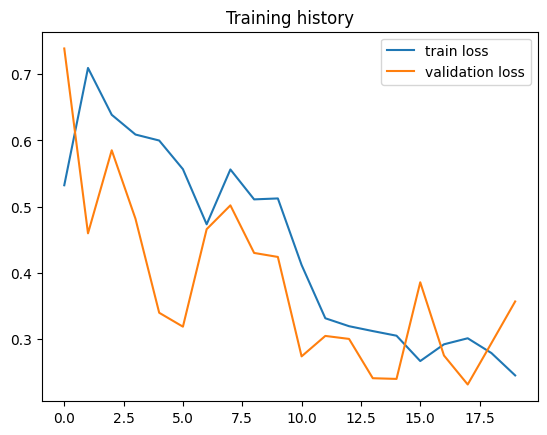

In [52]:
# Train the model
print("Starting training...")

import gc
EPOCHS = 20
SEED=123
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


gc.collect()
torch.cuda.empty_cache()


MODEL_RESULTS = train(model.to(device), 
                      train_dataloader, 
                      valid_dataloader, 
                      loss_fn, 
                      optimizer, 
                      EPOCHS)
print(MODEL_RESULTS)
# plot the training and validation loss
plt.plot(MODEL_RESULTS['train_loss'], label='train loss')
plt.plot(MODEL_RESULTS['valid_loss'], label='validation loss')
plt.legend()
plt.title('Training history')

In [53]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated(), torch.cuda.memory_reserved()


(171466752, 387973120)

In [54]:
# Load only model weights
state_dict = torch.load("best_model.pth", map_location=device)
# Load the best model for evaluation
best_model = WasteClassifier(num_classes=4, model_name="efficientnet_b2")  # Make sure to use the same architecture
best_model.load_state_dict(state_dict)
best_model.to(device)
best_model.eval()

print("Best model loaded successfully!")


Best model loaded successfully!


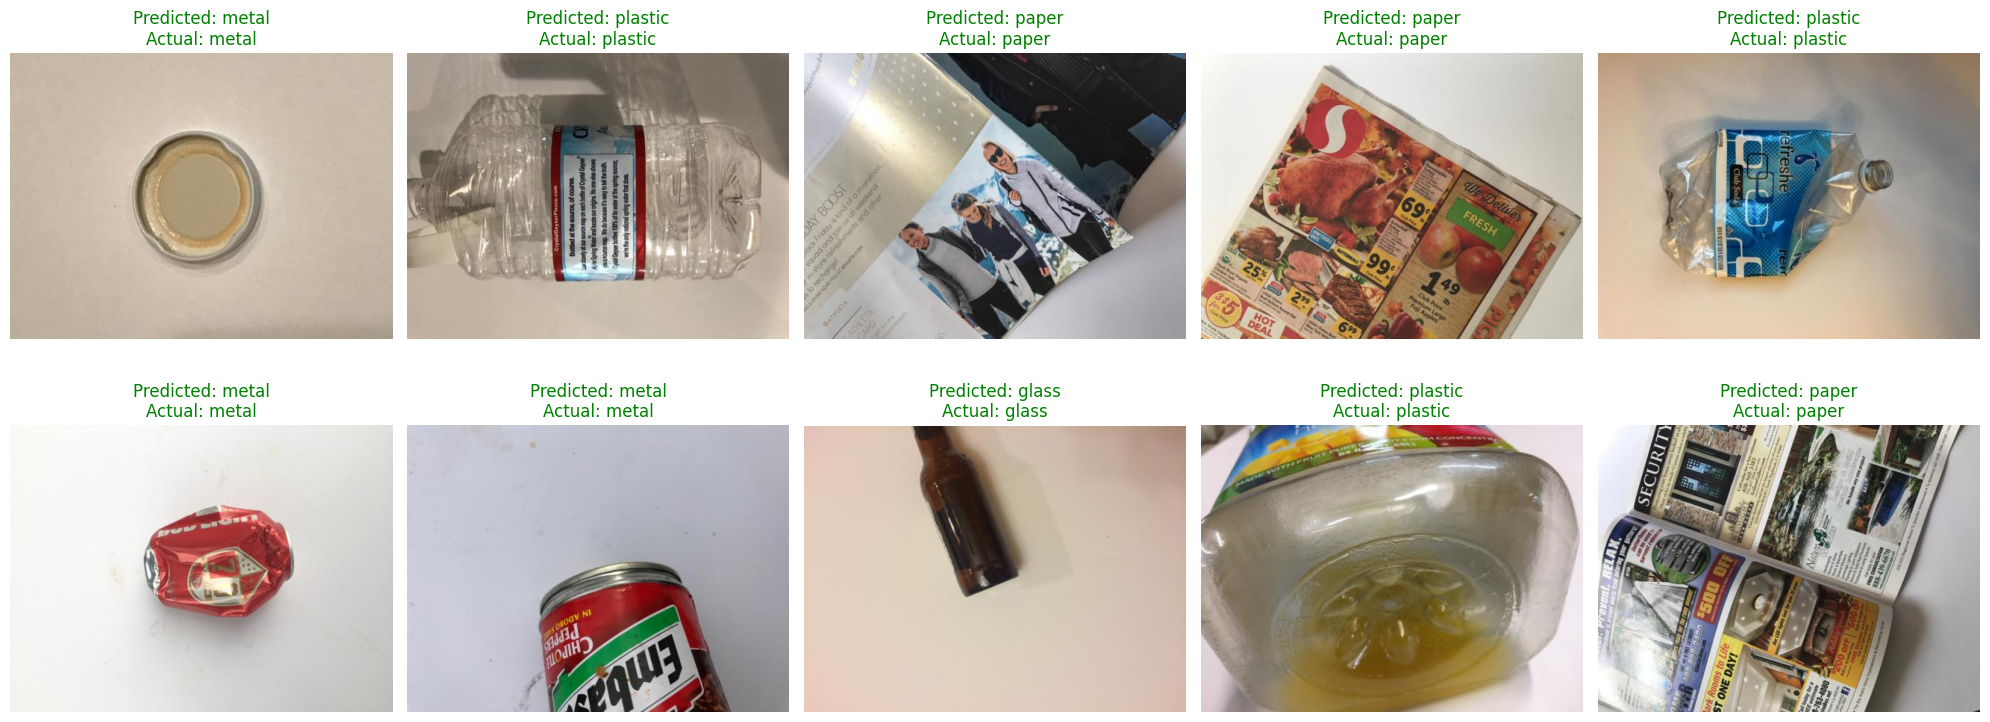

In [55]:
import random

# Select 10 random images from the test dataset
random_indices = random.sample(range(len(df_train)), 10)
random_images_paths = df_train.iloc[random_indices]['path'].values
random_images_labels = df_train.iloc[random_indices]['label'].values

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (image_path, image_label, ax) in enumerate(zip(random_images_paths, random_images_labels, axes)):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    transformed_image = valid_transforms(image).unsqueeze(0).to(device)

    # Get the model prediction
    best_model.eval()
    with torch.no_grad():
        output = best_model(transformed_image)
        _, predicted_label = torch.max(output, 1)

    # Map the predicted label back to the class name
    predicted_class = list(label_map.keys())[list(label_map.values()).index(predicted_label.item())]

    # Display the image and the prediction
    ax.imshow(image)
    if predicted_label.item() == image_label:
        ax.set_title(f'Predicted: {predicted_class}\nActual: {image_label}', color='green')
    else:
        ax.set_title(f'Predicted: {predicted_class}\nActual: {image_label}', color='red')
    ax.axis('off')
    # Map the actual label index back to the class name
    actual_class = list(label_map.keys())[list(label_map.values()).index(image_label)]

    # Display the image and the prediction
    ax.imshow(image)
    if predicted_label.item() == image_label:
        ax.set_title(f'Predicted: {predicted_class}\nActual: {actual_class}', color='green')
    else:
        ax.set_title(f'Predicted: {predicted_class}\nActual: {actual_class}', color='red')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [62]:
# Function to evaluate the model on the test dataset
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    # Define the inverse transformation
    inverse_transform = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ])
    with torch.no_grad():
        for batch in dataloader:
            # Check if the batch is None
            if batch is None:
                continue  # Skip this batch

            # Unpack the batch into images and labels
            images, labels = batch

            # Ensure images and labels are tensors before moving to device
            images, labels = images.to(device), labels.to(device)
                
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    actual_class = list(label_map.keys())[list(label_map.values()).index(labels[i].item())]
                    predicted_class = list(label_map.keys())[list(label_map.values()).index(predicted[i].item())]
                    print(f"Actual: {actual_class}, Predicted: {predicted_class}")
                    img = inverse_transform(images[i].cpu())
                    img = torch.clamp(img, 0, 1)
                    # plt.imshow(images[i].cpu().permute(1, 2, 0))
                    # plt.show()
    accuracy = 100 * correct / total
    return accuracy, [(images.cpu(), labels.cpu(), predicted.cpu()) for images, labels, predicted in zip(images, labels, predicted) if labels != predicted]

# Evaluate the best model on the test dataset
test_accuracy = evaluate_model(best_model, test_dataloader, device)
accuracy, misclassified_samples = test_accuracy
print(f'Test Accuracy: {accuracy:.2f}%')

Actual: plastic, Predicted: glass
Actual: plastic, Predicted: metal
Actual: metal, Predicted: glass
Actual: plastic, Predicted: metal
Actual: glass, Predicted: metal
Actual: glass, Predicted: metal
Actual: plastic, Predicted: paper
Actual: plastic, Predicted: glass
Actual: glass, Predicted: metal
Actual: plastic, Predicted: glass
Actual: paper, Predicted: plastic
Actual: plastic, Predicted: glass
Actual: glass, Predicted: metal
Actual: glass, Predicted: paper
Actual: metal, Predicted: glass
Test Accuracy: 94.98%


In [59]:
print("Label map from training:")
print(label_map)
print("\nClass order (sorted by label value):")
sorted_classes = sorted(label_map.items(), key=lambda x: x[1])
for class_name, label_idx in sorted_classes:
    print(f"{label_idx}: {class_name}")

Label map from training:
{'glass': 0, 'metal': 1, 'paper': 2, 'plastic': 3}

Class order (sorted by label value):
0: glass
1: metal
2: paper
3: plastic
